In [31]:
import numpy as np
import numba as nb 
from consav.linear_interp import interp_1d_vec
from EconModel import jit
from HANCModel import HANCModelClass
import matplotlib.pyplot as plt
from consav.grids import equilogspace
from consav.markov import log_rouwenhorst

# Compute transition

In [32]:
class Parameters:
    def __init__(self):
        # preferences
        self.beta = 0.9498866874132476
        self.sigma = 1.0
        
        # production
        self.alpha = 1/3
        self.delta = 0.1/3
        self.Gamma = 1.0
        
        # grids
        self.Na = 500
        self.a_min = 0.0
        self.a_max = 10_000.0 
        self.a_grid = equilogspace(self.a_min,self.a_max,self.Na)

        # income
        self.rho_z = 0.95
        self.sigma_psi = 0.30*(1.0-self.rho_z**2.0)**0.5
        self.Nz = 7
        self.z_grid, self.z_trans,self.z_ergodic,_,_ = log_rouwenhorst(self.rho_z,self.sigma_psi,self.Nz)
        

par = Parameters()

# Previous code

In [33]:
""" 
Household backward step
"""

def egm_ss(r, w, par, max_iter = 10_000, tol = 1e-8, verbose = False):
    """ solve the EGM for the steady state """

    # a. initialize
    y = w*par.z_grid
    c = r*par.a_grid[np.newaxis,:] + y[:,np.newaxis] 
    Va = (1+r)*c**(-par.sigma)

    # b. iterate
    for it in range(max_iter):

        # i. solve backwards
        c, a, Va_new = solve_hh_backwards_one_step(par.z_trans, par.z_grid, par.a_grid, par.sigma, par.beta, r, w, Va)

        # ii. check convergence
        error = np.max(np.abs(Va - Va_new))
        if verbose:
            print(error)
        if error < tol:
            break

        Va = Va_new.copy()

    return c, a, Va_new

def solve_hh_backwards_one_step(z_trans, z_grid, a_grid, sigma, beta, r, w, vbeg_a):

    Nz, Na = vbeg_a.shape
    a = np.zeros((Nz, Na))
    c = np.zeros((Nz, Na)) 
    
    # a. solve step
    for i_z in range(Nz):
    
        ## i. get c(a',z)
        c_endo = (beta*vbeg_a[i_z])**(-1/sigma)
        
        # ii. compute m_endo = c(a',z) + a'
        m_endo = c_endo + a_grid # current consumption + end-of-period assets
        
        # iii. interpolation to fixed grid
        m = (1+r)*a_grid + w*z_grid[i_z] # exogenous grid of coh
        interp_1d_vec(m_endo,a_grid,m,a[i_z]) # fill up the array a[i_z]
        a[i_z,:] = np.fmax(a[i_z,:],0.0) # enforce borrowing constraint
        c[i_z] = m-a[i_z]

    # b. expectation step
    RHS = (1+r)*c**(-sigma)
    vbeg_a_new = z_trans @ RHS

    return c, a, vbeg_a_new


In [34]:
""" 
Household forward step
"""

def get_lottery(a, a_grid):
    # step 1: find the i such that a' lies between gridpoints a_i and a_(i+1)
    a_i = np.searchsorted(a_grid, a, side='right') - 1
    a_i = np.clip(a_i, 0, len(a_grid)-2)

    # step 2: implement (8) to obtain lottery probabilities pi
    a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])
    
    return a_i, a_pi

@nb.njit
def forward_policy(D, a_i, a_pi):
    Dend = np.zeros_like(D)
    for e in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # send pi(e,a) of the mass to gridpoint i(e,a)
            Dend[e, a_i[e,a]] += a_pi[e,a]*D[e,a]
            
            # send 1-pi(e,a) of the mass to gridpoint i(e,a)+1
            Dend[e, a_i[e,a]+1] += (1-a_pi[e,a])*D[e,a]
            
    return Dend

def forward_iteration(D, z_trans, a_i, a_pi):
    Dend = forward_policy(D, a_i, a_pi)    
    return z_trans.T @ Dend

def distribution_ss(a, par, tol=1E-10):
    a_i, a_pi = get_lottery(a, par.a_grid)

    # as initial D, use stationary distribution for s, plus uniform over a
    D = par.z_ergodic[:, np.newaxis] * np.ones_like(par.a_grid) / len(par.a_grid)

    # now iterate until convergence to acceptable threshold
    for _ in range(100_000):
        D_new = forward_iteration(D, par.z_trans, a_i, a_pi)
        if np.max(np.abs(D_new - D)) < tol:
            return D_new
        D = D_new



In [35]:
""" 
Household block steady-state
"""

def household_ss(r, w, par, max_iter = 10_000, tol = 1e-8, verbose = False):
    c, a, Va = egm_ss(r, w, par, max_iter, tol, verbose) 
    D = distribution_ss(a, par)
    A = np.sum(D * a)
    C = np.sum(D * c) 
    return A, C, D, a, c, Va 

In [36]:
def find_ss_beta(beta, par):
    par.beta = beta
    r = 0.05
    w = 1-par.alpha
    K = 4 
    A, _, _, _, _, _  = household_ss(r, w, par) 
    print(A-K)
    return A-K

from scipy.optimize import brentq 
par.beta = brentq(find_ss_beta, 0.9, 0.952, args=(par,))

r_ss = 0.05 
Y_ss = 1 
K_ss = 4 
par.alpha = 1/3 
par.Gamma = Y_ss /(K_ss**par.alpha)
par.delta = par.alpha * par.Gamma * K_ss**(par.alpha-1) - r_ss
w_ss = (1-par.alpha) * Y_ss
A_ss, C_ss, D_init, a_ss, c_ss, Va_term = household_ss(r_ss, w_ss, par) 

-3.9999999999999987
18.850971301144178
-3.9999999999999964
-3.975423715491448
-3.690302699991704
-2.7649965573647464
-0.8924888421928925
1.3487170555343484
-0.21485529404579662
0.009983083845258811
-0.0004332611687845045
-8.180241333199945e-07
2.204991744747531e-11
-1.881705014028512e-09


# Partial equilibrium transition



In [37]:
T = 1000
r_vec = np.ones((T)) * r_ss
w_vec = np.ones((T)) * w_ss
w_vec[0] = w_vec[0] * 1.01

a_trans = np.zeros((T, par.Nz, par.Na))
c_trans = np.zeros((T, par.Nz, par.Na))
Va_trans = Va_term.copy()
for t in reversed(range(T)):
    c_trans[t], a_trans[t], Va_trans = solve_hh_backwards_one_step(par.z_trans, par.z_grid, par.a_grid, par.sigma, par.beta, r_vec[t], w_vec[t], Va_trans)

In [38]:
D_trans = np.zeros((T, par.Nz, par.Na))
D_trans[0] = D_init 

for t in range(T-1):
    a_i, a_pi = get_lottery(a_trans[t], par.a_grid)
    D_trans[t+1] = forward_iteration(D_trans[t], par.z_trans, a_i, a_pi)

In [39]:
A_trans = np.sum(D_trans * a_trans, axis = (1,2))
C_trans = np.sum(D_trans * c_trans, axis = (1,2))

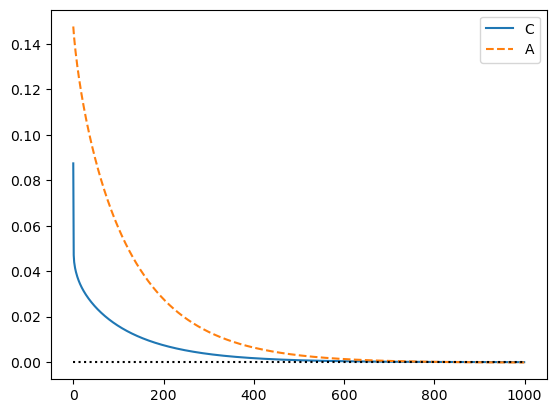

In [40]:
plt.plot(100*(C_trans-C_ss)/C_ss, label = 'C')
plt.plot(100*(A_trans-A_ss)/A_ss, label = 'A', linestyle = '--')
plt.plot(np.zeros_like(A_trans), linestyle = ':', color = 'black')
plt.legend()
plt.show()

In [41]:
def get_impulse_response(Va_term, D_init, r_vec, w_vec, par):
    # backward step
    a_trans = np.zeros((T, par.Nz, par.Na))
    c_trans = np.zeros((T, par.Nz, par.Na))
    Va_trans = Va_term.copy()
    for t in reversed(range(T)):
        c_trans[t], a_trans[t], Va_trans = solve_hh_backwards_one_step(par.z_trans, par.z_grid, par.a_grid, par.sigma, par.beta, r_vec[t], w_vec[t], Va_trans)

    # forward step
    D_trans = np.zeros((T, par.Nz, par.Na))
    D_trans[0] = D_init

    for t in range(T-1):
        a_i, a_pi = get_lottery(a_trans[t], par.a_grid)
        D_trans[t+1] = forward_iteration(D_trans[t], par.z_trans, a_i, a_pi)
    
    A_trans = np.sum(D_trans * a_trans, axis = (1,2))
    C_trans = np.sum(D_trans * c_trans, axis = (1,2))

    return C_trans, A_trans, D_trans, c_trans, a_trans

## Transitions in general equilibrium

In [42]:
def firm(K, Gamma, K_ss, par): 
    K_vec = K.copy()
    K_vec[1:] = K[:-1]
    K_vec[0] = K_ss 

    I = K - (1-par.delta) * K_vec

    r = par.alpha * Gamma * K_vec**(par.alpha-1) - par.delta
    Y = Gamma * K_vec**par.alpha
    w = (1-par.alpha) * Y
    return r, w, Y, I

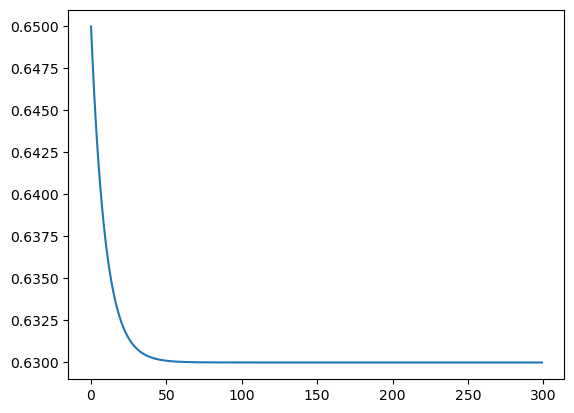

In [43]:
T = 300
sigma = 0.02
rho = 0.9
Gamma_shock = par.Gamma + sigma * rho ** np.arange(T)
plt.plot(Gamma_shock)

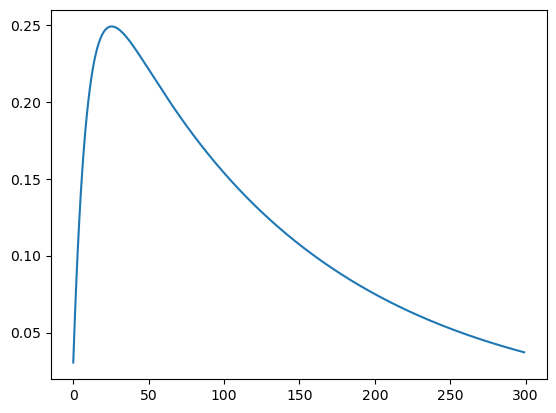

In [44]:
K_trans = np.ones((T)) * K_ss
r_trans, w_trans, Y_trans, I_trans, = firm(K_trans, Gamma_shock, K_ss, par)

C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
asset_market = A_trans - K_trans
plt.plot(asset_market)

In [47]:
K_trans = np.ones((T)) * K_ss
error = 1 
tol = 1e-8
adj = 0.1
while error > tol:
    r_trans, w_trans, Y_trans, I_trans = firm(K_trans, Gamma_shock, K_ss, par)
    C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
    asset_market = A_trans - K_trans
    error = np.max(np.abs(asset_market))
    print(error)
    K_trans = (1-adj) * K_trans + adj * A_trans


0.2488828875265936
0.1544943001810002
0.11629314131076463
0.08184290442863595
0.06443946153436109
0.051816277920314846
0.0423122323040781
0.034847185049770246
0.029040840964727366
0.024323109654705632
0.020455934113409846
0.017354366032796165
0.014760106333592482
0.012581361042418138
0.010745178918251774
0.009229979494804752
0.007951138989366058
0.006858772014134651
0.0059237831000693575
0.00512202947662832
0.004433383394306212
0.0038409957360610036
0.003340317031400808
0.002911902116687237
0.0025402880493787805
0.0022176122384838237
0.0019371627275708292
0.0016931974367153657
0.0014807945231325448
0.001295727651144496
0.0011343618698154145
0.0009935661025926024
0.0008706395629598518
0.0007632495918521442
0.0006696332767219815
0.0005896637532867288
0.0005194271352246815
0.0004577104231531237
0.00040345635743399555
0.0003557426768070471
0.0003137642479718039
0.00027681767335252516
0.0002442880099655653
0.00021563729363638373
0.0001903946103061216
0.00016814749722282585
0.000148534485817

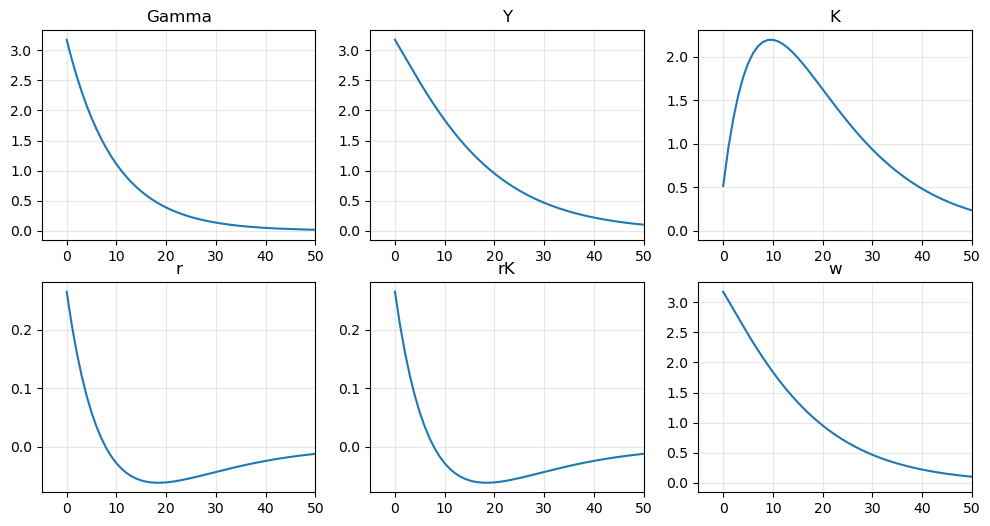

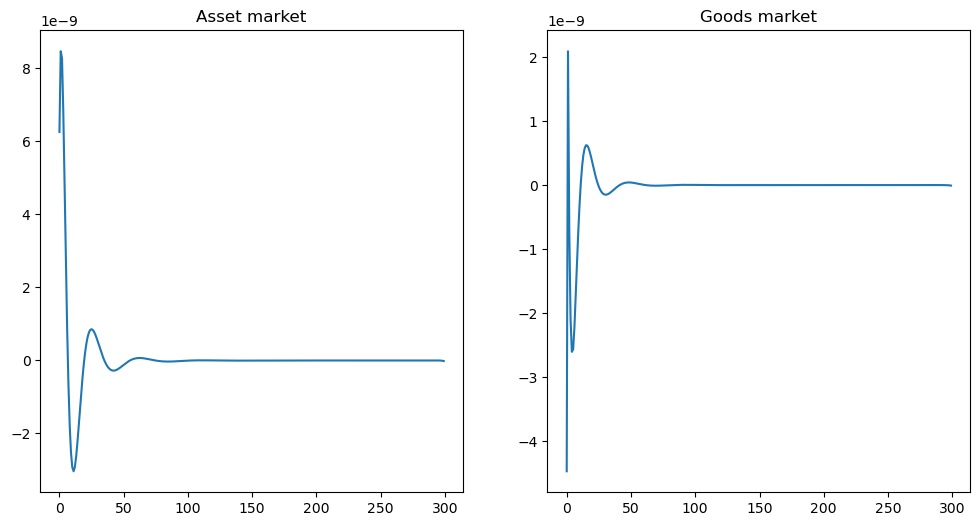

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

axes[0, 0].plot((Gamma_shock-par.Gamma)/par.Gamma * 100)
axes[0, 0].set_title('Gamma')
axes[0, 1].plot((Y_trans-Y_ss)/Y_ss * 100)
axes[0, 1].set_title('Y')
axes[0, 2].plot((K_trans-K_ss)/K_ss * 100)
axes[0, 2].set_title('K')
axes[1, 0].plot((r_trans-r_ss)* 100)
axes[1, 0].set_title('r')
axes[1, 1].plot((r_trans-r_ss)* 100)
axes[1, 1].set_title('rK')
axes[1, 2].plot((w_trans-w_ss) / w_ss* 100)
axes[1, 2].set_title('w')
for ax in axes.flat: 
    ax.set_xlim(-5, 50)
    ax.grid(True, alpha =0.3)
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(A_trans-K_trans)
axes[0].set_title('Asset market')
axes[1].plot(Y_trans - C_trans - I_trans)
axes[1].set_title('Goods market')
plt.show()

In [51]:
h = 1e-4
J_w = np.zeros((T, T))

for s in range(T):
    w_vec = np.ones((T)) * w
    w_vec[s] = w_vec[s] + h

    r_vec = np.ones((T)) * r 

    C_trans, A_trans, _, _, _ = get_impulse_response(Va, D, r_vec, w_vec, par)
    J_w[:,s] = (A_trans - A) / h



NameError: name 'w' is not defined